In [1]:
#import requests
#import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsRegressor

In [65]:
import scipy.stats
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score ,f1_score ,roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def Convert_Time(row): 
    tokens = row.split(':')
    if len(tokens) ==2:
        return int(tokens[0]) + int(tokens[1])/60
    
def Rest_days(row):
    if isinstance(row,int) or isinstance(row,float):
        return row
    tokens = row.split(' ')
    return int(tokens[0])

def get_matches_played_in_szn(df):
    df = df.copy()
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            team_df['Matches_Played'] = 1
            gd_cum = team_df['Matches_Played'].cumsum()
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    #cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum

def get_cum_by_col(df,grouper,grouper_name,cols,agg_func):
    df = df.copy()
    gp_arr=[]
    for team,team_df in df.groupby('Team'):
        for g,gd in team_df.groupby([grouper])[cols]:
            #print(g)
            #display(gd)
            if agg_func == 'sum':
                gd_cum = gd.shift(1).cumsum()
            if agg_func == 'mean':
                gd_cum = gd.shift(1).expanding().mean()
            for col in cols:
                gd_cum[col].fillna(gd_cum[col].mean(), inplace=True)
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    alias = '_this_'+grouper_name+'_'+agg_func
    cum_cols = [col+alias for col in cols]
    cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum 

def rolling_average_or_sum(df,cols,window,agg_func):
    df = df.copy()
    alias = '_last_'+str(window)+'gm_'+agg_func
    new_cols = [col+alias for col in cols]
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            #for g,gd in team_df.groupby([grouper])[cols]:
                if agg_func == 'sum':
                    rolling = team_df[cols].shift(1).rolling(window).sum()
                if agg_func == 'mean':
                    rolling = team_df[cols].shift(1).rolling(window).mean()
                    
                rolling.columns = new_cols   
                gp_arr.append(rolling)
    #display(rolling)
    rolling_df = pd.concat(gp_arr)
    rolling_df = rolling_df.sort_index()
    #rolling.columns = new_cols
    df_rolling = pd.concat([df,rolling_df],axis=1)
    return df_rolling

def Similar_Category2d(df,column,similar_categories_2d_array,category_array):
    df=df.copy()
    for idx,similar_categories1d in enumerate(similar_categories_2d_array):
        rows_with_matches = df[column].isin(similar_categories1d)
        df.loc[rows_with_matches,column] = category_array[idx]
        return df
    
def Cat_Code(df,columns):
    df=df.copy()
    for col in columns:
        new_feature = col+'_code'
        df[new_feature] = df[col].astype("category").cat.codes
    return df

def get_Cum_Sum_Avg(df,cols,agg_func):
    df = df.copy()
    for col in cols:
        new_feature = col+'_Total_'+agg_func
        if agg_func == 'sum':
            df[new_feature] = df[col].shift(1).cumsum()
        if agg_func == 'mean':
            df[new_feature] = df[col].shift(1).expanding().mean()
    return df

def missing_percentage(df):
    """A function for returning missing ratios."""
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])




In [5]:
advance_stats_cols = 'Standard_Gls	Standard_Sh	Standard_SoT	Standard_SoT%	Standard_G/Sh	Standard_G/SoT	Standard_Dist	Standard_FK	Standard_PK	Standard_PKatt	Expected_xG	Expected_npxG	Expected_npxG/Sh	Expected_G-xG	Expected_np:G-xG	SCA_Types_SCA	SCA_Types_PassLive	SCA_Types_PassDead	SCA_Types_Drib	SCA_Types_Sh	SCA_Types_Fld	SCA_Types_Def	GCA_Types_GCA	GCA_Types_PassLive	GCA_Types_PassDead	GCA_Types_Drib	GCA_Types_Sh	GCA_Types_Fld	GCA_Types_Def	Tackles_Tkl	Tackles_TklW	Tackles_Def_3rd	Tackles_Mid_3rd	Tackles_Att_3rd	Vs_Dribbles_Tkl	Vs_Dribbles_Att	Vs_Dribbles_Tkl%	Vs_Dribbles_Past	Pressures_Press	Pressures_Succ	Pressures_%	Pressures_Def_3rd	Pressures_Mid_3rd	Pressures_Att_3rd	Blocks_Blocks	Blocks_Sh	Blocks_ShSv	Blocks_Pass	Def_Int	Def_Tkl+Int	Def_Clr	Def_Err	GK_Perf_SoTA	GK_Perf_GA	GK_Perf_Saves	GK_Perf_Save%	GK_Perf_CS	GK_Perf_PSxG	GK_Perf_PSxG+/-	GK_Penalty_PKatt	GK_Penalty_PKA	GK_Penalty_PKsv	GK_Penalty_PKm	GK_Launch_Cmp	GK_Launch_Att	GK_Launch_Cmp%	GK_Passes_Att	GK_Passes_Thr	GK_Passes_Launch%	GK_Passes_AvgLen	Gk_Goal_Kk_Att	Gk_Goal_Kk_Launch%	Gk_Goal_Kk_AvgLen	GK_Crosses_Opp	GK_Crosses_Stp	GK_Crosses_Stp%	Gk_Sweeper_#OPA	Gk_Sweeper_AvgDist	Passing_Total_Cmp	Passing_Total_Att	Passing_Total_Cmp%	Passing_Total_TotDist	Passing_Total_PrgDist	Passing_Short_Cmp	Passing_Short_Att	Passing_Short_Cmp%	Passing_Medium_Cmp	Passing_Medium_Att	Passing_Medium_Cmp%	Passing_Long_Cmp	Passing_Long_Att	Passing_Long_Cmp%	Passing_Ast	Passing_xA	Passing_KP	Passing_1/3	Passing_PPA	Passing_CrsPA	Passing_Prog	Misc_Stats_CrdY	Misc_Stats_CrdR	Misc_Stats_2CrdY	Misc_Stats_Fls	Misc_Stats_Fld	Misc_Stats_Off	Misc_Stats_Crs	Misc_Stats_Int	Misc_Stats_TklW	Misc_Stats_PKwon	Misc_Stats_PKcon	Misc_Stats_OG	Misc_Stats_Recov	Misc_Stats_Aerial_DuelsWon	Misc_Stats_Aerial_DuelsLost	Misc_Stats_Aerial_DuelsWon%'.split('	')

In [7]:
len(advance_stats_cols)

115

In [42]:
def Feature_Engineering(df):
    df=df.copy()
    #First_Match_In_Month
    first_occurence_idx = []
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            for column,column_df in team_df.groupby('Month'):
                first_occurence_idx.append(column_df.index[0])
                
    df.loc[first_occurence_idx,'First_Match_In_Month'] = 1
    df['First_Match_In_Month'].replace(np.nan, 0, inplace=True)
    
    #First_Match_With_Formation
    first_occurence_idx = []
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            for column,column_df in team_df.groupby('Formation'):
                first_occurence_idx.append(column_df.index[0])
    
    df.loc[first_occurence_idx,'First_Match_With_Formation'] = 1
    df['First_Match_With_Formation'].replace(np.nan, 0, inplace=True)
    
    #Gameweek
    df = get_matches_played_in_szn(df)
    
    #Opponent
    mask = df['Opponent'].str.contains('eng')
    df.loc[mask,'Opponent'] = df.loc[mask,'Opponent'].replace('eng ',"",regex=True) 
    
    df['Opponent_Count'] =  df['Opponent'].map(df.Opponent.value_counts().to_dict())
    
    arr = ['zeros','ones','twos','threes','fours','fives','sixs','sevens','eights','nines']
    no = [str(x) for x  in list(range(0,10))]
    no_dict = dict(zip(no,arr))
    for key,value in df.Opponent.value_counts().to_dict().items():
        if value <10:
            #print(key,no_dict[str(value)])
            mask = df.Opponent==key
            df.loc[mask,'Opponent'] = no_dict[str(value)]
    
    #top4 and top 7
    top7 = ['Chelsea','Manchester City','Liverpool','Tottenham','Manchester Utd','Arsenal','Leicester City']
    top4 = ['Chelsea','Manchester City','Liverpool','Manchester Utd']
    
    df['Top7_Opp'] = df.apply(lambda x : 1 if x.Opponent in top7  else 0 ,axis=1)
    df['Top7_Team'] = df.apply(lambda x : 1 if x.Team in top7  else 0 ,axis=1)
    df['Top4_Opp'] = df.apply(lambda x : 1 if x.Opponent in top4  else 0 ,axis=1)
    df['Top4_Team'] = df.apply(lambda x : 1 if x.Team in top4  else 0 ,axis=1)
    #------------------------->>>>>>>>>>>>>>>>>.
    
    #Referees
    df['Referee_Count'] =  df['Referee'].map(df.Referee.value_counts().to_dict())
    
    for key,value in df.Referee.value_counts().to_dict().items():
        if value <10:
            #print(key,no_dict[str(value)])
            mask = df.Referee==key
            df.loc[mask,'Referee'] = no_dict[str(value)]

    #ref_ranking
    top_refs = ['Michael Oliver','Anthony Taylor','Darren England','Paul Tierney','Andre Marriner',
            'Andy Madley','Stuart Attwell','Mike Dean','Craig Pawson','Martin Atkinson','Jonathan Moss',
            'David Coote','Kevin Friend','Jarred Gillett','Robert Jones','Peter Bankes','Graham Scott',
            'Chris Kavanagh','Simon Hooper',
           ]
    ref_Ranking = [8,7.5,7,7,6.5,6,5.5,5.5,5,5,5,5,5,5,4.5,4.5,4,4,4,]
    df['top20_Ref'] = df.apply(lambda x : 1 if x.Referee in top_refs  else 0 ,axis=1)
    df['top5_Ref'] = df.apply(lambda x : 1 if x.Referee in top_refs[:5]  else 0 ,axis=1)
    
    lg = ['Post_Season_Cup', 'Premier League', 'Europa', 'EFL Cup', 'FA Cup',
       'Champions Lg']
    df['Ref_rank'] = df['Referee'].map(dict(zip(top_refs,ref_Ranking)))
    rank_na = [7,3,6,5,5,7]
    for comp,rank in zip(lg,rank_na):
            mask = (df.Comp==comp)
            df.loc[mask,'Ref_rank'] = df.loc[mask,'Ref_rank'].fillna(rank)

    #---------------------->>>>>>>>>>>>>>>>> 
    #Time
    df.loc[:,'Time'] = df.Time.apply(Convert_Time)
    #Rest
    df.loc[:,'Rest'] = df.Rest.apply(Rest_days)
    
    #Comp
    df = Similar_Category2d(df,column='Comp',
                   similar_categories_2d_array=[['Europa Lg','Conf Lg'],['Community Shield','Super Cup']],
                   category_array=['Europa','Post_Season_Cup'])
    
    #drop ['Prev_match_date',Prev_comp',Prev_Opp']
    df.drop(['Prev_match_date','Prev_comp','Prev_Opp'],axis=1,inplace=True)
    
    #Prev_comp',Prev_Opp'
    df['Prev_comp'] = df.Comp.shift(1)
    df['Prev_Opp'] = df.Opponent.shift(1)
    
    #captain
    df['Captain_Count'] =  df['Captain'].map(df.Captain.value_counts().to_dict())
    df['Captain_Rank'] = df['Captain_Rank'].astype("category").cat.codes
    
    #get_cum_by_col
    df=get_cum_by_col(df=df,grouper='Comp',grouper_name='Comp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Top7_Opp',grouper_name='7_Opp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Top4_Opp',grouper_name='4_Opp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Ref_rank',grouper_name='Ref',cols=['Win','Lose','Draw','GF','GA'],agg_func='sum')
    
    df = get_cum_by_col(df,grouper='Comp',grouper_name='Comp',cols=['Poss','GF','GA','Win','Lose'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Top7_Opp',grouper_name='7_Opp',cols=['Poss','GF','GA','Win','Lose','Draw'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Ref_rank',grouper_name='Ref_rank',cols=['Poss','GF','GA','Win','Lose','Draw'],agg_func='mean')
    
    #cat_code
    cat_cols = ['Comp','Day','Venue','Opponent','Captain','Formation','Referee','Team','Prev_comp', 'Prev_Opp']
    df = Cat_Code(df=df,columns=cat_cols)
    
    #Month is a cyclic feature
    ##Gabriel Atkin
    df.loc[:,'Cyclic_Month'] = (-np.cos(0.5236 * df['Month']))
    
    #advance_stats_rolling
    #fillna
    for col in advance_stats_cols:
        df[col].replace(np.nan, 0, inplace=True)
    
    df = rolling_average_or_sum(df=df,cols=advance_stats_cols,window=2,agg_func='sum') #last2gm
    df = rolling_average_or_sum(df=df,cols=advance_stats_cols,window=3,agg_func='mean') #lats3gm
    
    df = get_Cum_Sum_Avg(df=df,cols=advance_stats_cols,agg_func='sum') # cum sum
    df = get_Cum_Sum_Avg(df=df,cols=advance_stats_cols,agg_func='mean') #cum avg
    #Na_Count
    df['Na_count'] = df.apply(lambda x :len(x) - x.count(),axis=1)
    
    #fill_na
    fill_with_zero = 'Total_Points	Total_GF	Total_GA	Total_Win	Total_Draw	Total_Loss	Points_Avg_for_szn	GF_Avg_for_szn	GA_Avg_for_szn	Win_Avg_for_szn	Draw_Avg_for_szn	Loss_Avg_for_szn'.split('	')
    for col in fill_with_zero:
        df[col].replace(np.nan, 0, inplace=True)
    
    return df

In [62]:
def predictions(data,predictors,targets,model):
    data = data.copy()
    train = data[data["Season"] < 2022]
    test = data[data["Season"] == 2022]
    combination = []
    for target in targets:
        model.fit(train[predictors], train[target])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        error = accuracy_score(test[target], preds)
        print(f"{target} Accuracy Score : ",error)
        print()
        col ="predicted_"+target
        combined = pd.DataFrame(dict(actual=test[target], predicted=preds))
        combined.columns = ['actual',col]
        combination.append(combined) 
        display(pd.crosstab(index=combined["actual"], columns=combined[col]))
        if target == 'Points':
            print(f"{target} Precision _Macro_Micro : ",precision_score(test[target], preds, average = 'macro'),precision_score(test[target], preds, average = 'micro'))# print("Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score _Macro_Micro : ",f1_score(test[target], preds, average = 'macro'),f1_score(test[target], preds, average = 'micro'))
            #print(f"{target} ROC _Macro_Micro : ",roc_auc_score(test[target], preds, average = 'macro'),roc_auc_score(test[target], preds, average = 'micro'))
        else:
            print(f"{target} Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score : ",f1_score(test[target], preds))
            print(f"{target} ROC : ",roc_auc_score(test[target], preds))
        print()
        print()
    combinations = pd.concat(combination,axis=1)
    combinations = combinations.merge(test[["Team", "Opponent", "Result"]], left_index=True, right_index=True)
    return combinations

In [66]:
def make_mi_scores_Classif(X_train, y_train):
    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X_train.dtypes == int
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(20,14))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [12]:
df  = pd.read_csv("C:\\Users\\user\\Solo Dolo\\EPL Analysis\\All_team_data2.csv")

In [18]:
df.shape

(4783, 249)

In [43]:
df2 = Feature_Engineering(df=df)

In [44]:
df2.shape

(4783, 788)

In [14]:
df2.head()

,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Team,Standard_Gls,Standard_Sh,Standard_SoT,Standard_SoT%,Standard_G/Sh,Standard_G/SoT,Standard_Dist,Standard_FK,Standard_PK,Standard_PKatt,Expected_xG,Expected_npxG,Expected_npxG/Sh,Expected_G-xG,Expected_np:G-xG,SCA_Types_SCA,SCA_Types_PassLive,SCA_Types_PassDead,SCA_Types_Drib,SCA_Types_Sh,SCA_Types_Fld,SCA_Types_Def,GCA_Types_GCA,GCA_Types_PassLive,GCA_Types_PassDead,GCA_Types_Drib,GCA_Types_Sh,GCA_Types_Fld,GCA_Types_Def,Tackles_Tkl,Tackles_TklW,Tackles_Def_3rd,Tackles_Mid_3rd,Tackles_Att_3rd,Vs_Dribbles_Tkl,Vs_Dribbles_Att,Vs_Dribbles_Tkl%,Vs_Dribbles_Past,Pressures_Press,Pressures_Succ,Pressures_%,Pressures_Def_3rd,Pressures_Mid_3rd,Pressures_Att_3rd,Blocks_Blocks,Blocks_Sh,Blocks_ShSv,Blocks_Pass,Def_Int,Def_Tkl+Int,Def_Clr,Def_Err,GK_Perf_SoTA,GK_Perf_GA,GK_Perf_Saves,GK_Perf_Save%,GK_Perf_CS,GK_Perf_PSxG,GK_Perf_PSxG+/-,GK_Penalty_PKatt,GK_Penalty_PKA,GK_Penalty_PKsv,GK_Penalty_PKm,GK_Launch_Cmp,GK_Launch_Att,GK_Launch_Cmp%,GK_Passes_Att,GK_Passes_Thr,GK_Passes_Launch%,GK_Passes_AvgLen,Gk_Goal_Kk_Att,Gk_Goal_Kk_Launch%,Gk_Goal_Kk_AvgLen,GK_Crosses_Opp,GK_Crosses_Stp,GK_Crosses_Stp%,Gk_Sweeper_#OPA,Gk_Sweeper_AvgDist,Passing_Total_Cmp,Passing_Total_Att,Passing_Total_Cmp%,Passing_Total_TotDist,Passing_Total_PrgDist,Passing_Short_Cmp,Passing_Short_Att,Passing_Short_Cmp%,Passing_Medium_Cmp,Passing_Medium_Att,Passing_Medium_Cmp%,Passing_Long_Cmp,Passing_Long_Att,Passing_Long_Cmp%,Passing_Ast,Passing_xA,Passing_KP,Passing_1/3,Passing_PPA,Passing_CrsPA,Passing_Prog,Misc_Stats_CrdY,Misc_Stats_CrdR,Misc_Stats_2CrdY,Misc_Stats_Fls,Misc_Stats_Fld,Misc_Stats_Off,Misc_Stats_Crs,Misc_Stats_Int,Misc_Stats_TklW,Misc_Stats_PKwon,Misc_Stats_PKcon,Misc_Stats_OG,Misc_Stats_Recov,Misc_Stats_Aerial_DuelsWon,Misc_Stats_Aerial_DuelsLost,Misc_Stats_Aerial_DuelsWon%,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Oppo

In [20]:
drops =['Unnamed: 0','Date','Round','Poss','Attendance','Notes','Attendance','xG','xGA','Match Report']
drops.extend(advance_stats_cols)

In [22]:
len(drops)

125

In [23]:
new_stats='Standard_Gls_last_2gm_sum	Standard_Sh_last_2gm_sum	Standard_SoT_last_2gm_sum	Standard_SoT%_last_2gm_sum	Standard_G/Sh_last_2gm_sum	Standard_G/SoT_last_2gm_sum	Standard_Dist_last_2gm_sum	Standard_FK_last_2gm_sum	Standard_PK_last_2gm_sum	Standard_PKatt_last_2gm_sum	Expected_xG_last_2gm_sum	Expected_npxG_last_2gm_sum	Expected_npxG/Sh_last_2gm_sum	Expected_G-xG_last_2gm_sum	Expected_np:G-xG_last_2gm_sum	SCA_Types_SCA_last_2gm_sum	SCA_Types_PassLive_last_2gm_sum	SCA_Types_PassDead_last_2gm_sum	SCA_Types_Drib_last_2gm_sum	SCA_Types_Sh_last_2gm_sum	SCA_Types_Fld_last_2gm_sum	SCA_Types_Def_last_2gm_sum	GCA_Types_GCA_last_2gm_sum	GCA_Types_PassLive_last_2gm_sum	GCA_Types_PassDead_last_2gm_sum	GCA_Types_Drib_last_2gm_sum	GCA_Types_Sh_last_2gm_sum	GCA_Types_Fld_last_2gm_sum	GCA_Types_Def_last_2gm_sum	Tackles_Tkl_last_2gm_sum	Tackles_TklW_last_2gm_sum	Tackles_Def_3rd_last_2gm_sum	Tackles_Mid_3rd_last_2gm_sum	Tackles_Att_3rd_last_2gm_sum	Vs_Dribbles_Tkl_last_2gm_sum	Vs_Dribbles_Att_last_2gm_sum	Vs_Dribbles_Tkl%_last_2gm_sum	Vs_Dribbles_Past_last_2gm_sum	Pressures_Press_last_2gm_sum	Pressures_Succ_last_2gm_sum	Pressures_%_last_2gm_sum	Pressures_Def_3rd_last_2gm_sum	Pressures_Mid_3rd_last_2gm_sum	Pressures_Att_3rd_last_2gm_sum	Blocks_Blocks_last_2gm_sum	Blocks_Sh_last_2gm_sum	Blocks_ShSv_last_2gm_sum	Blocks_Pass_last_2gm_sum	Def_Int_last_2gm_sum	Def_Tkl+Int_last_2gm_sum	Def_Clr_last_2gm_sum	Def_Err_last_2gm_sum	GK_Perf_SoTA_last_2gm_sum	GK_Perf_GA_last_2gm_sum	GK_Perf_Saves_last_2gm_sum	GK_Perf_Save%_last_2gm_sum	GK_Perf_CS_last_2gm_sum	GK_Perf_PSxG_last_2gm_sum	GK_Perf_PSxG+/-_last_2gm_sum	GK_Penalty_PKatt_last_2gm_sum	GK_Penalty_PKA_last_2gm_sum	GK_Penalty_PKsv_last_2gm_sum	GK_Penalty_PKm_last_2gm_sum	GK_Launch_Cmp_last_2gm_sum	GK_Launch_Att_last_2gm_sum	GK_Launch_Cmp%_last_2gm_sum	GK_Passes_Att_last_2gm_sum	GK_Passes_Thr_last_2gm_sum	GK_Passes_Launch%_last_2gm_sum	GK_Passes_AvgLen_last_2gm_sum	Gk_Goal_Kk_Att_last_2gm_sum	Gk_Goal_Kk_Launch%_last_2gm_sum	Gk_Goal_Kk_AvgLen_last_2gm_sum	GK_Crosses_Opp_last_2gm_sum	GK_Crosses_Stp_last_2gm_sum	GK_Crosses_Stp%_last_2gm_sum	Gk_Sweeper_#OPA_last_2gm_sum	Gk_Sweeper_AvgDist_last_2gm_sum	Passing_Total_Cmp_last_2gm_sum	Passing_Total_Att_last_2gm_sum	Passing_Total_Cmp%_last_2gm_sum	Passing_Total_TotDist_last_2gm_sum	Passing_Total_PrgDist_last_2gm_sum	Passing_Short_Cmp_last_2gm_sum	Passing_Short_Att_last_2gm_sum	Passing_Short_Cmp%_last_2gm_sum	Passing_Medium_Cmp_last_2gm_sum	Passing_Medium_Att_last_2gm_sum	Passing_Medium_Cmp%_last_2gm_sum	Passing_Long_Cmp_last_2gm_sum	Passing_Long_Att_last_2gm_sum	Passing_Long_Cmp%_last_2gm_sum	Passing_Ast_last_2gm_sum	Passing_xA_last_2gm_sum	Passing_KP_last_2gm_sum	Passing_1/3_last_2gm_sum	Passing_PPA_last_2gm_sum	Passing_CrsPA_last_2gm_sum	Passing_Prog_last_2gm_sum	Misc_Stats_CrdY_last_2gm_sum	Misc_Stats_CrdR_last_2gm_sum	Misc_Stats_2CrdY_last_2gm_sum	Misc_Stats_Fls_last_2gm_sum	Misc_Stats_Fld_last_2gm_sum	Misc_Stats_Off_last_2gm_sum	Misc_Stats_Crs_last_2gm_sum	Misc_Stats_Int_last_2gm_sum	Misc_Stats_TklW_last_2gm_sum	Misc_Stats_PKwon_last_2gm_sum	Misc_Stats_PKcon_last_2gm_sum	Misc_Stats_OG_last_2gm_sum	Misc_Stats_Recov_last_2gm_sum	Misc_Stats_Aerial_DuelsWon_last_2gm_sum	Misc_Stats_Aerial_DuelsLost_last_2gm_sum	Misc_Stats_Aerial_DuelsWon%_last_2gm_sum	Standard_Gls_last_3gm_mean	Standard_Sh_last_3gm_mean	Standard_SoT_last_3gm_mean	Standard_SoT%_last_3gm_mean	Standard_G/Sh_last_3gm_mean	Standard_G/SoT_last_3gm_mean	Standard_Dist_last_3gm_mean	Standard_FK_last_3gm_mean	Standard_PK_last_3gm_mean	Standard_PKatt_last_3gm_mean	Expected_xG_last_3gm_mean	Expected_npxG_last_3gm_mean	Expected_npxG/Sh_last_3gm_mean	Expected_G-xG_last_3gm_mean	Expected_np:G-xG_last_3gm_mean	SCA_Types_SCA_last_3gm_mean	SCA_Types_PassLive_last_3gm_mean	SCA_Types_PassDead_last_3gm_mean	SCA_Types_Drib_last_3gm_mean	SCA_Types_Sh_last_3gm_mean	SCA_Types_Fld_last_3gm_mean	SCA_Types_Def_last_3gm_mean	GCA_Types_GCA_last_3gm_mean	GCA_Types_PassLive_last_3gm_mean	GCA_Types_PassDead_last_3gm_mean	GCA_Types_Drib_last_3gm_mean	GCA_Types_Sh_last_3gm_mean	GCA_Types_Fld_last_3gm_mean	GCA_Types_Def_last_3gm_mean	Tackles_Tkl_last_3gm_mean	Tackles_TklW_last_3gm_mean	Tackles_Def_3rd_last_3gm_mean	Tackles_Mid_3rd_last_3gm_mean	Tackles_Att_3rd_last_3gm_mean	Vs_Dribbles_Tkl_last_3gm_mean	Vs_Dribbles_Att_last_3gm_mean	Vs_Dribbles_Tkl%_last_3gm_mean	Vs_Dribbles_Past_last_3gm_mean	Pressures_Press_last_3gm_mean	Pressures_Succ_last_3gm_mean	Pressures_%_last_3gm_mean	Pressures_Def_3rd_last_3gm_mean	Pressures_Mid_3rd_last_3gm_mean	Pressures_Att_3rd_last_3gm_mean	Blocks_Blocks_last_3gm_mean	Blocks_Sh_last_3gm_mean	Blocks_ShSv_last_3gm_mean	Blocks_Pass_last_3gm_mean	Def_Int_last_3gm_mean	Def_Tkl+Int_last_3gm_mean	Def_Clr_last_3gm_mean	Def_Err_last_3gm_mean	GK_Perf_SoTA_last_3gm_mean	GK_Perf_GA_last_3gm_mean	GK_Perf_Saves_last_3gm_mean	GK_Perf_Save%_last_3gm_mean	GK_Perf_CS_last_3gm_mean	GK_Perf_PSxG_last_3gm_mean	GK_Perf_PSxG+/-_last_3gm_mean	GK_Penalty_PKatt_last_3gm_mean	GK_Penalty_PKA_last_3gm_mean	GK_Penalty_PKsv_last_3gm_mean	GK_Penalty_PKm_last_3gm_mean	GK_Launch_Cmp_last_3gm_mean	GK_Launch_Att_last_3gm_mean	GK_Launch_Cmp%_last_3gm_mean	GK_Passes_Att_last_3gm_mean	GK_Passes_Thr_last_3gm_mean	GK_Passes_Launch%_last_3gm_mean	GK_Passes_AvgLen_last_3gm_mean	Gk_Goal_Kk_Att_last_3gm_mean	Gk_Goal_Kk_Launch%_last_3gm_mean	Gk_Goal_Kk_AvgLen_last_3gm_mean	GK_Crosses_Opp_last_3gm_mean	GK_Crosses_Stp_last_3gm_mean	GK_Crosses_Stp%_last_3gm_mean	Gk_Sweeper_#OPA_last_3gm_mean	Gk_Sweeper_AvgDist_last_3gm_mean	Passing_Total_Cmp_last_3gm_mean	Passing_Total_Att_last_3gm_mean	Passing_Total_Cmp%_last_3gm_mean	Passing_Total_TotDist_last_3gm_mean	Passing_Total_PrgDist_last_3gm_mean	Passing_Short_Cmp_last_3gm_mean	Passing_Short_Att_last_3gm_mean	Passing_Short_Cmp%_last_3gm_mean	Passing_Medium_Cmp_last_3gm_mean	Passing_Medium_Att_last_3gm_mean	Passing_Medium_Cmp%_last_3gm_mean	Passing_Long_Cmp_last_3gm_mean	Passing_Long_Att_last_3gm_mean	Passing_Long_Cmp%_last_3gm_mean	Passing_Ast_last_3gm_mean	Passing_xA_last_3gm_mean	Passing_KP_last_3gm_mean	Passing_1/3_last_3gm_mean	Passing_PPA_last_3gm_mean	Passing_CrsPA_last_3gm_mean	Passing_Prog_last_3gm_mean	Misc_Stats_CrdY_last_3gm_mean	Misc_Stats_CrdR_last_3gm_mean	Misc_Stats_2CrdY_last_3gm_mean	Misc_Stats_Fls_last_3gm_mean	Misc_Stats_Fld_last_3gm_mean	Misc_Stats_Off_last_3gm_mean	Misc_Stats_Crs_last_3gm_mean	Misc_Stats_Int_last_3gm_mean	Misc_Stats_TklW_last_3gm_mean	Misc_Stats_PKwon_last_3gm_mean	Misc_Stats_PKcon_last_3gm_mean	Misc_Stats_OG_last_3gm_mean	Misc_Stats_Recov_last_3gm_mean	Misc_Stats_Aerial_DuelsWon_last_3gm_mean	Misc_Stats_Aerial_DuelsLost_last_3gm_mean	Misc_Stats_Aerial_DuelsWon%_last_3gm_mean	Standard_Gls_Total_sum	Standard_Sh_Total_sum	Standard_SoT_Total_sum	Standard_SoT%_Total_sum	Standard_G/Sh_Total_sum	Standard_G/SoT_Total_sum	Standard_Dist_Total_sum	Standard_FK_Total_sum	Standard_PK_Total_sum	Standard_PKatt_Total_sum	Expected_xG_Total_sum	Expected_npxG_Total_sum	Expected_npxG/Sh_Total_sum	Expected_G-xG_Total_sum	Expected_np:G-xG_Total_sum	SCA_Types_SCA_Total_sum	SCA_Types_PassLive_Total_sum	SCA_Types_PassDead_Total_sum	SCA_Types_Drib_Total_sum	SCA_Types_Sh_Total_sum	SCA_Types_Fld_Total_sum	SCA_Types_Def_Total_sum	GCA_Types_GCA_Total_sum	GCA_Types_PassLive_Total_sum	GCA_Types_PassDead_Total_sum	GCA_Types_Drib_Total_sum	GCA_Types_Sh_Total_sum	GCA_Types_Fld_Total_sum	GCA_Types_Def_Total_sum	Tackles_Tkl_Total_sum	Tackles_TklW_Total_sum	Tackles_Def_3rd_Total_sum	Tackles_Mid_3rd_Total_sum	Tackles_Att_3rd_Total_sum	Vs_Dribbles_Tkl_Total_sum	Vs_Dribbles_Att_Total_sum	Vs_Dribbles_Tkl%_Total_sum	Vs_Dribbles_Past_Total_sum	Pressures_Press_Total_sum	Pressures_Succ_Total_sum	Pressures_%_Total_sum	Pressures_Def_3rd_Total_sum	Pressures_Mid_3rd_Total_sum	Pressures_Att_3rd_Total_sum	Blocks_Blocks_Total_sum	Blocks_Sh_Total_sum	Blocks_ShSv_Total_sum	Blocks_Pass_Total_sum	Def_Int_Total_sum	Def_Tkl+Int_Total_sum	Def_Clr_Total_sum	Def_Err_Total_sum	GK_Perf_SoTA_Total_sum	GK_Perf_GA_Total_sum	GK_Perf_Saves_Total_sum	GK_Perf_Save%_Total_sum	GK_Perf_CS_Total_sum	GK_Perf_PSxG_Total_sum	GK_Perf_PSxG+/-_Total_sum	GK_Penalty_PKatt_Total_sum	GK_Penalty_PKA_Total_sum	GK_Penalty_PKsv_Total_sum	GK_Penalty_PKm_Total_sum	GK_Launch_Cmp_Total_sum	GK_Launch_Att_Total_sum	GK_Launch_Cmp%_Total_sum	GK_Passes_Att_Total_sum	GK_Passes_Thr_Total_sum	GK_Passes_Launch%_Total_sum	GK_Passes_AvgLen_Total_sum	Gk_Goal_Kk_Att_Total_sum	Gk_Goal_Kk_Launch%_Total_sum	Gk_Goal_Kk_AvgLen_Total_sum	GK_Crosses_Opp_Total_sum	GK_Crosses_Stp_Total_sum	GK_Crosses_Stp%_Total_sum	Gk_Sweeper_#OPA_Total_sum	Gk_Sweeper_AvgDist_Total_sum	Passing_Total_Cmp_Total_sum	Passing_Total_Att_Total_sum	Passing_Total_Cmp%_Total_sum	Passing_Total_TotDist_Total_sum	Passing_Total_PrgDist_Total_sum	Passing_Short_Cmp_Total_sum	Passing_Short_Att_Total_sum	Passing_Short_Cmp%_Total_sum	Passing_Medium_Cmp_Total_sum	Passing_Medium_Att_Total_sum	Passing_Medium_Cmp%_Total_sum	Passing_Long_Cmp_Total_sum	Passing_Long_Att_Total_sum	Passing_Long_Cmp%_Total_sum	Passing_Ast_Total_sum	Passing_xA_Total_sum	Passing_KP_Total_sum	Passing_1/3_Total_sum	Passing_PPA_Total_sum	Passing_CrsPA_Total_sum	Passing_Prog_Total_sum	Misc_Stats_CrdY_Total_sum	Misc_Stats_CrdR_Total_sum	Misc_Stats_2CrdY_Total_sum	Misc_Stats_Fls_Total_sum	Misc_Stats_Fld_Total_sum	Misc_Stats_Off_Total_sum	Misc_Stats_Crs_Total_sum	Misc_Stats_Int_Total_sum	Misc_Stats_TklW_Total_sum	Misc_Stats_PKwon_Total_sum	Misc_Stats_PKcon_Total_sum	Misc_Stats_OG_Total_sum	Misc_Stats_Recov_Total_sum	Misc_Stats_Aerial_DuelsWon_Total_sum	Misc_Stats_Aerial_DuelsLost_Total_sum	Misc_Stats_Aerial_DuelsWon%_Total_sum	Standard_Gls_Total_mean	Standard_Sh_Total_mean	Standard_SoT_Total_mean	Standard_SoT%_Total_mean	Standard_G/Sh_Total_mean	Standard_G/SoT_Total_mean	Standard_Dist_Total_mean	Standard_FK_Total_mean	Standard_PK_Total_mean	Standard_PKatt_Total_mean	Expected_xG_Total_mean	Expected_npxG_Total_mean	Expected_npxG/Sh_Total_mean	Expected_G-xG_Total_mean	Expected_np:G-xG_Total_mean	SCA_Types_SCA_Total_mean	SCA_Types_PassLive_Total_mean	SCA_Types_PassDead_Total_mean	SCA_Types_Drib_Total_mean	SCA_Types_Sh_Total_mean	SCA_Types_Fld_Total_mean	SCA_Types_Def_Total_mean	GCA_Types_GCA_Total_mean	GCA_Types_PassLive_Total_mean	GCA_Types_PassDead_Total_mean	GCA_Types_Drib_Total_mean	GCA_Types_Sh_Total_mean	GCA_Types_Fld_Total_mean	GCA_Types_Def_Total_mean	Tackles_Tkl_Total_mean	Tackles_TklW_Total_mean	Tackles_Def_3rd_Total_mean	Tackles_Mid_3rd_Total_mean	Tackles_Att_3rd_Total_mean	Vs_Dribbles_Tkl_Total_mean	Vs_Dribbles_Att_Total_mean	Vs_Dribbles_Tkl%_Total_mean	Vs_Dribbles_Past_Total_mean	Pressures_Press_Total_mean	Pressures_Succ_Total_mean	Pressures_%_Total_mean	Pressures_Def_3rd_Total_mean	Pressures_Mid_3rd_Total_mean	Pressures_Att_3rd_Total_mean	Blocks_Blocks_Total_mean	Blocks_Sh_Total_mean	Blocks_ShSv_Total_mean	Blocks_Pass_Total_mean	Def_Int_Total_mean	Def_Tkl+Int_Total_mean	Def_Clr_Total_mean	Def_Err_Total_mean	GK_Perf_SoTA_Total_mean	GK_Perf_GA_Total_mean	GK_Perf_Saves_Total_mean	GK_Perf_Save%_Total_mean	GK_Perf_CS_Total_mean	GK_Perf_PSxG_Total_mean	GK_Perf_PSxG+/-_Total_mean	GK_Penalty_PKatt_Total_mean	GK_Penalty_PKA_Total_mean	GK_Penalty_PKsv_Total_mean	GK_Penalty_PKm_Total_mean	GK_Launch_Cmp_Total_mean	GK_Launch_Att_Total_mean	GK_Launch_Cmp%_Total_mean	GK_Passes_Att_Total_mean	GK_Passes_Thr_Total_mean	GK_Passes_Launch%_Total_mean	GK_Passes_AvgLen_Total_mean	Gk_Goal_Kk_Att_Total_mean	Gk_Goal_Kk_Launch%_Total_mean	Gk_Goal_Kk_AvgLen_Total_mean	GK_Crosses_Opp_Total_mean	GK_Crosses_Stp_Total_mean	GK_Crosses_Stp%_Total_mean	Gk_Sweeper_#OPA_Total_mean	Gk_Sweeper_AvgDist_Total_mean	Passing_Total_Cmp_Total_mean	Passing_Total_Att_Total_mean	Passing_Total_Cmp%_Total_mean	Passing_Total_TotDist_Total_mean	Passing_Total_PrgDist_Total_mean	Passing_Short_Cmp_Total_mean	Passing_Short_Att_Total_mean	Passing_Short_Cmp%_Total_mean	Passing_Medium_Cmp_Total_mean	Passing_Medium_Att_Total_mean	Passing_Medium_Cmp%_Total_mean	Passing_Long_Cmp_Total_mean	Passing_Long_Att_Total_mean	Passing_Long_Cmp%_Total_mean	Passing_Ast_Total_mean	Passing_xA_Total_mean	Passing_KP_Total_mean	Passing_1/3_Total_mean	Passing_PPA_Total_mean	Passing_CrsPA_Total_mean	Passing_Prog_Total_mean	Misc_Stats_CrdY_Total_mean	Misc_Stats_CrdR_Total_mean	Misc_Stats_2CrdY_Total_mean	Misc_Stats_Fls_Total_mean	Misc_Stats_Fld_Total_mean	Misc_Stats_Off_Total_mean	Misc_Stats_Crs_Total_mean	Misc_Stats_Int_Total_mean	Misc_Stats_TklW_Total_mean	Misc_Stats_PKwon_Total_mean	Misc_Stats_PKcon_Total_mean	Misc_Stats_OG_Total_mean	Misc_Stats_Recov_Total_mean	Misc_Stats_Aerial_DuelsWon_Total_mean	Misc_Stats_Aerial_DuelsLost_Total_mean	Misc_Stats_Aerial_DuelsWon%_Total_mean'.split('	')

In [24]:
len(new_stats)

460

In [25]:
new_stats

['Standard_Gls_last_2gm_sum',
 'Standard_Sh_last_2gm_sum',
 'Standard_SoT_last_2gm_sum',
 'Standard_SoT%_last_2gm_sum',
 'Standard_G/Sh_last_2gm_sum',
 'Standard_G/SoT_last_2gm_sum',
 'Standard_Dist_last_2gm_sum',
 'Standard_FK_last_2gm_sum',
 'Standard_PK_last_2gm_sum',
 'Standard_PKatt_last_2gm_sum',
 'Expected_xG_last_2gm_sum',
 'Expected_npxG_last_2gm_sum',
 'Expected_npxG/Sh_last_2gm_sum',
 'Expected_G-xG_last_2gm_sum',
 'Expected_np:G-xG_last_2gm_sum',
 'SCA_Types_SCA_last_2gm_sum',
 'SCA_Types_PassLive_last_2gm_sum',
 'SCA_Types_PassDead_last_2gm_sum',
 'SCA_Types_Drib_last_2gm_sum',
 'SCA_Types_Sh_last_2gm_sum',
 'SCA_Types_Fld_last_2gm_sum',
 'SCA_Types_Def_last_2gm_sum',
 'GCA_Types_GCA_last_2gm_sum',
 'GCA_Types_PassLive_last_2gm_sum',
 'GCA_Types_PassDead_last_2gm_sum',
 'GCA_Types_Drib_last_2gm_sum',
 'GCA_Types_Sh_last_2gm_sum',
 'GCA_Types_Fld_last_2gm_sum',
 'GCA_Types_Def_last_2gm_sum',
 'Tackles_Tkl_last_2gm_sum',
 'Tackles_TklW_last_2gm_sum',
 'Tackles_Def_3rd_last_2

,Standard_Gls_last_2gm_sum,GK_Launch_Cmp_last_2gm_sum,GK_Crosses_Opp_last_2gm_sum,Gk_Goal_Kk_AvgLen_last_2gm_sum,Gk_Goal_Kk_Launch%_last_2gm_sum,Gk_Goal_Kk_Att_last_2gm_sum,GK_Passes_AvgLen_last_2gm_sum,GK_Passes_Launch%_last_2gm_sum,GK_Passes_Thr_last_2gm_sum,GK_Passes_Att_last_2gm_sum,GK_Launch_Cmp%_last_2gm_sum,GK_Launch_Att_last_2gm_sum,GK_Penalty_PKm_last_2gm_sum,Standard_Sh_last_2gm_sum,GK_Penalty_PKsv_last_2gm_sum,GK_Penalty_PKA_last_2gm_sum,GK_Penalty_PKatt_last_2gm_sum,GK_Perf_PSxG+/-_last_2gm_sum,GK_Perf_PSxG_last_2gm_sum,GK_Perf_CS_last_2gm_sum,GK_Perf_Save%_last_2gm_sum,GK_Perf_Saves_last_2gm_sum,GK_Perf_GA_last_2gm_sum,GK_Perf_SoTA_last_2gm_sum,GK_Crosses_Stp_last_2gm_sum,GK_Crosses_Stp%_last_2gm_sum,Gk_Sweeper_#OPA_last_2gm_sum,Gk_Sweeper_AvgDist_last_2gm_sum,Passing_Prog_last_2gm_sum,Passing_CrsPA_last_2gm_sum,Passing_PPA_last_2gm_sum,Passing_1/3_last_2gm_sum,Passing_KP_last_2gm_sum,Passing_xA_last_2gm_sum,Passing_Ast_last_2gm_sum,Passing_Long_Cmp%_last_2gm_sum,Passing_Long_Att_last_2gm_sum,Passing_Long_Cmp_last_2gm_sum,Passing_Medium_Cmp%_last_2gm_sum,Passing_Medium_Att_last_2gm_sum,Passing_Medium_Cmp_last_2gm_sum,Passing_Short_Cmp%_last_2gm_sum,Passing_Short_Att_last_2gm_sum,Passing_Short_Cmp_last_2gm_sum,Passing_Total_PrgDist_last_2gm_sum,Passing_Total_TotDist_last_2gm_sum,Passing_Total_Cmp%_last_2gm_sum,Passing_Total_Att_last_2gm_sum,Passing_Total_Cmp_last_2gm_sum,Def_Err_last_2gm_sum,Def_Clr_last_2gm_sum,Def_Tkl+Int_last_2gm_sum,GCA_Types_PassDead_last_2gm_sum,GCA_Types_GCA_last_2gm_sum,SCA_Types_Def_last_2gm_sum,SCA_Types_Fld_last_2gm_sum,SCA_Types_Sh_last_2gm_sum,SCA_Types_Drib_last_2gm_sum,SCA_Types_PassDead_last_2gm_sum,SCA_Types_PassLive_last_2gm_sum,SCA_Types_SCA_last_2gm_sum,Expected_np:G-xG_last_2gm_sum,Expected_G-xG_last_2gm_sum,Expected_npxG/Sh_last_2gm_sum,Expected_npxG_last_2gm_sum,Expected_xG_last_2gm_sum,Standard_PKatt_last_2gm_sum,Standard_PK_last_2gm_sum,Standard_FK_last_2gm_sum,Standard_Dist_last_2gm_sum,Standard_G/SoT_last_2gm_sum,Standard_G/Sh_last_2gm_sum,Standard_SoT%_last_2gm_sum,Standard_SoT_last_2gm_sum,GCA_Types_PassLive_last_2gm_sum,GCA_Types_Drib_last_2gm_sum,Def_Int_last_2gm_sum,GCA_Types_Sh_last_2gm_sum,Blocks_Pass_last_2gm_sum,Blocks_ShSv_last_2gm_sum,Blocks_Sh_last_2gm_sum,Blocks_Blocks_last_2gm_sum,Pressures_Att_3rd_last_2gm_sum,Pressures_Mid_3rd_last_2gm_sum,Pressures_Def_3rd_last_2gm_sum,Pressures_%_last_2gm_sum,Pressures_Succ_last_2gm_sum,Pressures_Press_last_2gm_sum,Vs_Dribbles_Past_last_2gm_sum,Vs_Dribbles_Tkl%_last_2gm_sum,Vs_Dribbles_Att_last_2gm_sum,Vs_Dribbles_Tkl_last_2gm_sum,Tackles_Att_3rd_last_2gm_sum,Tackles_Mid_3rd_last_2gm_sum,Tackles_Def_3rd_last_2gm_sum,Tackles_TklW_last_2gm_sum,Tackles_Tkl_last_2gm_sum,GCA_Types_Def_last_2gm_sum,GCA_Types_Fld_last_2gm_sum,Misc_Stats_CrdY_last_2gm_sum
Total,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
Percent,4.181476,4.181476,4.181476,4.181476,4.181476,4.181476,4.181476,4.181476,4.181476,4

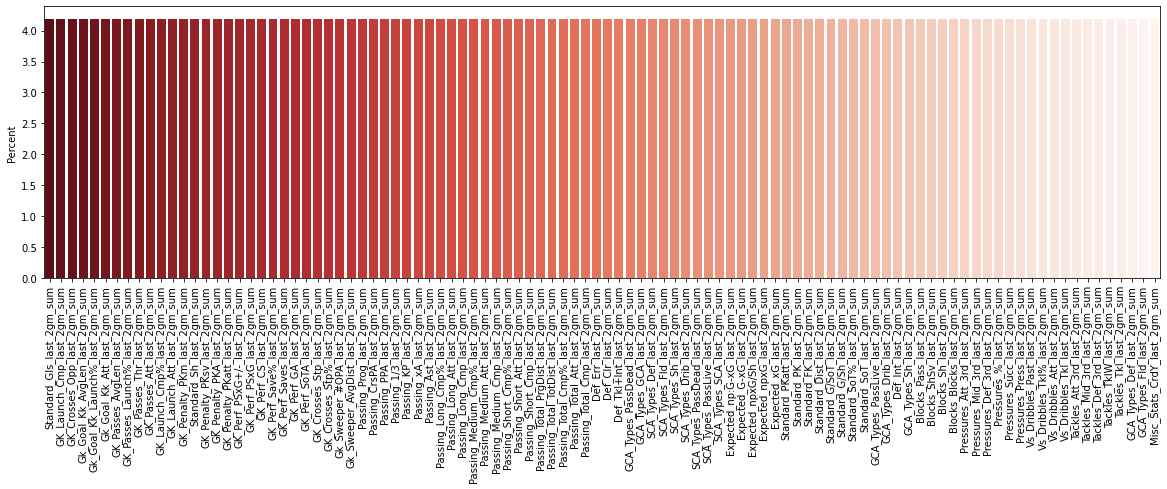

In [45]:
missing = missing_percentage(df2[new_stats[:100]])

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

In [27]:
df2.shape

(4783, 788)

In [28]:
4783-1578

3205

,Def_Tkl+Int_last_3gm_mean,Gk_Sweeper_AvgDist_last_3gm_mean,GK_Crosses_Stp%_last_3gm_mean,Gk_Goal_Kk_Launch%_last_3gm_mean,Gk_Goal_Kk_AvgLen_last_3gm_mean,GK_Launch_Cmp%_last_3gm_mean,Expected_npxG/Sh_last_3gm_mean,Standard_Dist_last_3gm_mean,Def_Clr_last_3gm_mean,Blocks_Pass_last_3gm_mean,Blocks_ShSv_last_3gm_mean,Blocks_Sh_last_3gm_mean,Blocks_Blocks_last_3gm_mean,Pressures_Att_3rd_last_3gm_mean,Vs_Dribbles_Att_last_3gm_mean,Def_Err_last_3gm_mean,Pressures_Def_3rd_last_3gm_mean,Pressures_%_last_3gm_mean,Pressures_Succ_last_3gm_mean,Pressures_Press_last_3gm_mean,Vs_Dribbles_Past_last_3gm_mean,Vs_Dribbles_Tkl%_last_3gm_mean,Vs_Dribbles_Tkl_last_3gm_mean,Tackles_Att_3rd_last_3gm_mean,Pressures_Mid_3rd_last_3gm_mean,GK_Launch_Att_last_3gm_mean,GK_Perf_PSxG_last_3gm_mean,GK_Crosses_Stp_last_3gm_mean,Passing_Short_Cmp_last_3gm_mean,Passing_Total_PrgDist_last_3gm_mean,Passing_Total_TotDist_last_3gm_mean,Passing_Total_Cmp%_last_3gm_mean,Passing_Total_Att_last_3gm_mean,Passing_Total_Cmp_last_3gm_mean,Gk_Sweeper_#OPA_last_3gm_mean,GK_Crosses_Opp_last_3gm_mean,GK_Perf_PSxG+/-_last_3gm_mean,Gk_Goal_Kk_Att_last_3gm_mean,GK_Passes_AvgLen_last_3gm_mean,GK_Passes_Launch%_last_3gm_mean,GK_Passes_Thr_last_3gm_mean,GK_Passes_Att_last_3gm_mean,Tackles_Def_3rd_last_3gm_mean,GK_Launch_Cmp_last_3gm_mean,Tackles_Mid_3rd_last_3gm_mean,Passing_Short_Att_last_3gm_mean,Expected_G-xG_last_3gm_mean,SCA_Types_Fld_last_3gm_mean,Tackles_Tkl_last_3gm_mean,Expected_xG_last_3gm_mean,Standard_FK_last_3gm_mean,Expected_npxG_last_3gm_mean,Expected_np:G-xG_last_3gm_mean,SCA_Types_SCA_last_3gm_mean,SCA_Types_PassDead_last_3gm_mean,SCA_Types_Drib_last_3gm_mean,SCA_Types_Sh_last_3gm_mean,SCA_Types_PassLive_last_3gm_mean,SCA_Types_Def_last_3gm_mean,GCA_Types_PassLive_last_3gm_mean,GCA_Types_PassDead_last_3gm_mean,GCA_Types_Def_last_3gm_mean,GCA_Types_Drib_last_3gm_mean,GCA_Types_Fld_last_3gm_mean,GCA_Types_Sh_last_3gm_mean,GCA_Types_GCA_last_3gm_mean,Misc_Stats_Aerial_DuelsWon%_last_2gm_sum,Misc_Stats_Recov_last_2gm_sum,Misc_Stats_Aerial_DuelsWon_last_2gm_sum,Misc_Stats_Aerial_DuelsLost_last_2gm_sum,Misc_Stats_PKwon_last_2gm_sum,Misc_Stats_PKcon_last_2gm_sum,GK_Perf_Save%_last_3gm_mean,Standard_G/SoT_last_3gm_mean,Standard_SoT%_last_3gm_mean,Standard_G/Sh_last_3gm_mean,Standard_SoT_last_3gm_mean,Tackles_TklW_last_3gm_mean,GK_Perf_Saves_last_3gm_mean,GK_Perf_SoTA_last_3gm_mean,Def_Int_last_3gm_mean,Standard_Sh_last_3gm_mean,GK_Perf_GA_last_3gm_mean,GK_Perf_CS_last_3gm_mean,Standard_Gls_last_3gm_mean,Standard_PKatt_last_3gm_mean,Standard_PK_last_3gm_mean,GK_Penalty_PKm_last_3gm_mean,GK_Penalty_PKsv_last_3gm_mean,GK_Penalty_PKA_last_3gm_mean,GK_Penalty_PKatt_last_3gm_mean,Misc_Stats_Off_last_2gm_sum,Misc_Stats_TklW_last_2gm_sum,Misc_Stats_Int_last_2gm_sum,Misc_Stats_Crs_last_2gm_sum,Misc_Stats_Fld_last_2gm_sum,Misc_Stats_Fls_last_2gm_sum,Misc_Stats_OG_last_2gm_sum,Misc_Stats_2CrdY_last_2gm_sum,Misc_Stats_CrdR_last_2gm_sum
Total,4783.000000,2189.000000,2151.000000,2150.000000,2150.000000,2128.000000,2126.000000,2126.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,2120.000000,1522.000000,1522.000000,1522.000000,1522.000000,1067.000000,1067.000000,877.000000,773.000000,370.000000,370.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,336.000000,318.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,3

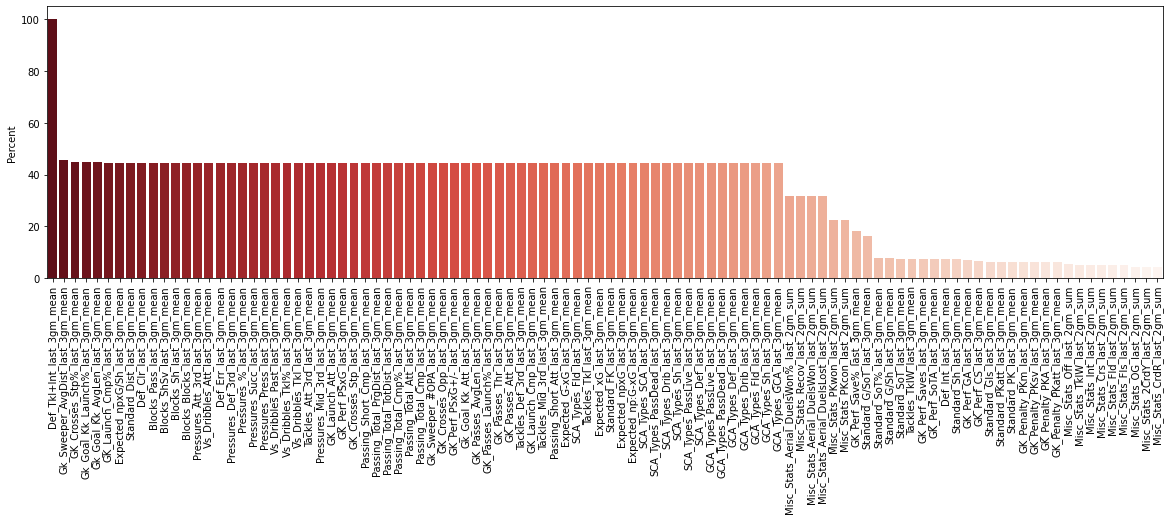

In [29]:
missing = missing_percentage(df2[new_stats[100:200]])

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

In [46]:
missing_df = missing_percentage(df2[new_stats])

In [48]:
missing_df[missing_df.Percent>10]

,Total,Percent


In [37]:
len(new_stats),df2.shape

(460, (4783, 788))

In [49]:
missing_df = missing_percentage(df2.drop(drops,axis=1))

In [52]:
missing_df[missing_df.Percent>5].index

Index(['Poss_mean_prev_month_', 'Away_Loss_sum_prev_month_',
       'GA_mean_prev_month_', 'Home_Draw_sum_prev_month_',
       'Home_Win_sum_prev_month_', 'Away_Draw_sum_prev_month_',
       'Away_Win_sum_prev_month_', 'GA_sum_prev_month_', 'GF_sum_prev_month_',
       'GF_mean_prev_month_',
       ...
       'GK_Passes_Launch%_last_3gm_mean', 'GK_Passes_Thr_last_3gm_mean',
       'Poss_this_Opp_mean', 'Lose_this_Opp_sum', 'GF_this_Opp_sum',
       'Draw_this_Opp_sum', 'GA_this_Opp_sum', 'Win_this_Opp_sum',
       'GF_this_Opp_mean', 'GA_this_Opp_mean'],
      dtype='object', length=147)

In [53]:
df3 = df2.drop(drops,axis=1)

In [54]:
df4 = df3.dropna()

In [56]:
df4.shape

(3779, 664)

In [58]:
predictors = df4.columns.drop([ 'Result',
 'GF',
 'GA', 'Win',
 'Draw',
 'Lose',
 'Points', 'Away_Win',
 'Away_Draw',
 'Away_Loss',
 'Home_Win',
 'Home_Draw',
 'Home_Loss','Result','Comp','Day','Venue','Opponent','Captain','Formation','Referee','Team','Prev_comp', 'Prev_Opp'])

In [60]:
predictors.to_list()

['Time',
 'Season',
 'Month',
 'Total_Points',
 'Total_GF',
 'Total_GA',
 'Total_Win',
 'Total_Draw',
 'Total_Loss',
 'Points_Avg_for_szn',
 'GF_Avg_for_szn',
 'GA_Avg_for_szn',
 'Win_Avg_for_szn',
 'Draw_Avg_for_szn',
 'Loss_Avg_for_szn',
 'Points_last_1gm_sum',
 'Win_last_1gm_sum',
 'Draw_last_1gm_sum',
 'Lose_last_1gm_sum',
 'GF_last_1gm_sum',
 'GA_last_1gm_sum',
 'Away_Win_last_1gm_sum',
 'Away_Draw_last_1gm_sum',
 'Away_Loss_last_1gm_sum',
 'Home_Win_last_1gm_sum',
 'Home_Draw_last_1gm_sum',
 'Home_Loss_last_1gm_sum',
 'Points_last_2gm_sum',
 'Win_last_2gm_sum',
 'Draw_last_2gm_sum',
 'Lose_last_2gm_sum',
 'GF_last_2gm_sum',
 'GA_last_2gm_sum',
 'Away_Win_last_2gm_sum',
 'Away_Draw_last_2gm_sum',
 'Away_Loss_last_2gm_sum',
 'Home_Win_last_2gm_sum',
 'Home_Draw_last_2gm_sum',
 'Home_Loss_last_2gm_sum',
 'Points_last_3gm_mean',
 'Win_last_3gm_mean',
 'Draw_last_3gm_mean',
 'Lose_last_3gm_mean',
 'GF_last_3gm_mean',
 'GA_last_3gm_mean',
 'Away_Win_last_3gm_mean',
 'Away_Draw_last_3gm

In [61]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=1)

In [64]:
first_batch = predictions(data=df4,predictors=predictors,targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6742934051144011



predicted_Win,0.0,1.0
actual,,
0,443,4
1,238,58


Win Precision :  0.9354838709677419
Win F1_score :  0.3240223463687151
Win ROC :  0.5934987000423243


Draw Accuracy Score :  0.7792732166890982



predicted_Draw,0.0,1.0
actual,,
0,569,1
1,163,10


Draw Precision :  0.9090909090909091
Draw F1_score :  0.10869565217391304
Draw ROC :  0.5280245411215901


Lose Accuracy Score :  0.7187079407806191



predicted_Lose,0.0,1.0
actual,,
0,465,4
1,205,69


Lose Precision :  0.9452054794520548
Lose F1_score :  0.39769452449567727
Lose ROC :  0.6216480164350303


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




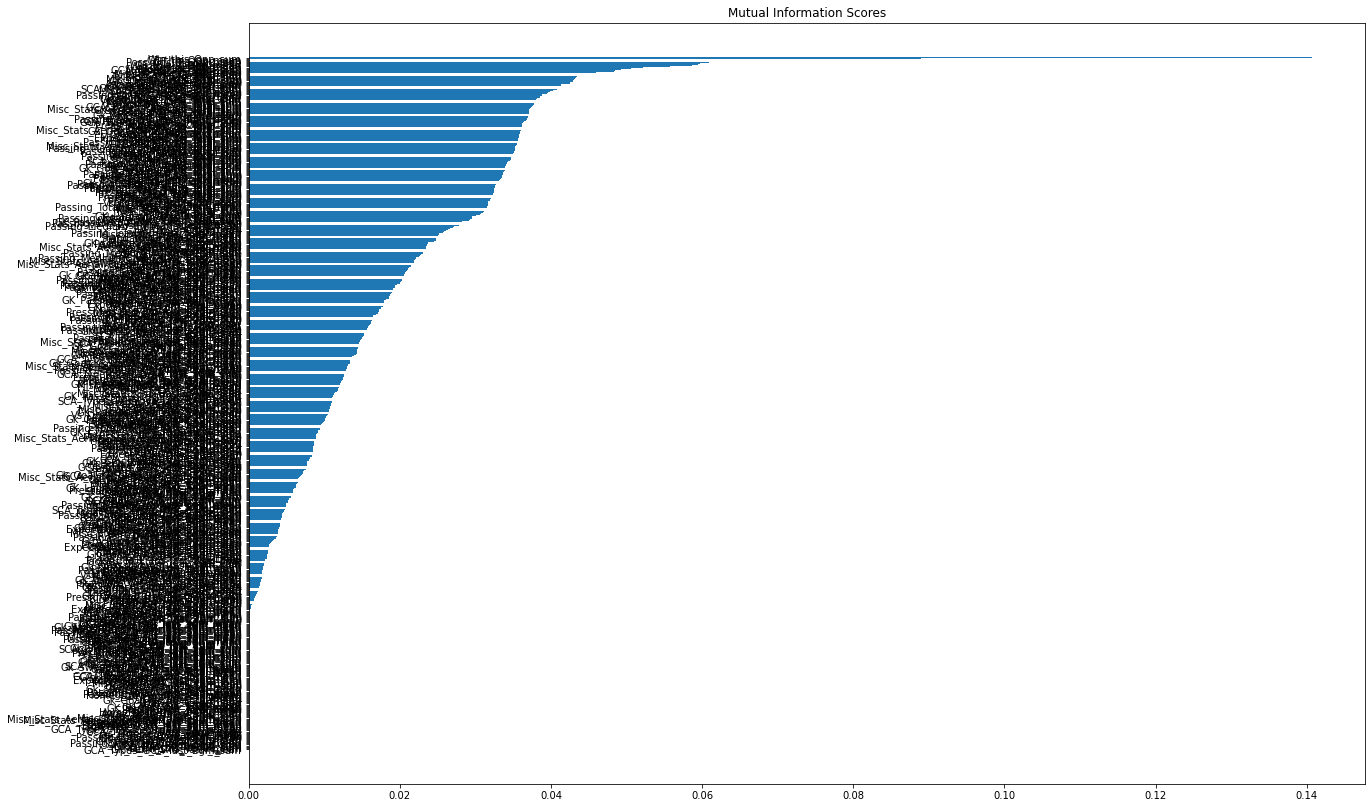

In [67]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=df4[predictors], y_train=df4['Win'])
plot_mi_scores(scores=mi_scores_win)

In [84]:
mi_scores_win.index[:200]

Index(['Win_this_Opp_sum', 'GF_this_Opp_mean', 'GF_this_Opp_sum',
       'Poss_this_7_Opp_mean', 'Captain_code', 'GF_this_7_Opp_mean',
       'Win_this_7_Opp_mean', 'Lose_this_Opp_sum', 'GA_this_Opp_mean',
       'Standard_PK_Total_sum',
       ...
       'Misc_Stats_Aerial_DuelsWon_last_3gm_mean', 'Lose_this_Ref_rank_mean',
       'Standard_Dist_Total_mean', 'GK_Perf_GA_Total_sum',
       'GK_Perf_Saves_last_3gm_mean', 'Poss_this_month_mean',
       'GF_sum_prev_month_', 'Passing_Total_Cmp%_Total_mean',
       'Passing_PPA_last_3gm_mean', 'Tackles_TklW_Total_mean'],
      dtype='object', length=200)

In [69]:
mi_scores_win.to_dict()

{'Win_this_Opp_sum': 0.14064692888465857,
 'GF_this_Opp_mean': 0.08891199726104482,
 'GF_this_Opp_sum': 0.06955214451641978,
 'Poss_this_7_Opp_mean': 0.06682118705884932,
 'Captain_code': 0.060918343487380566,
 'GF_this_7_Opp_mean': 0.05965527251983982,
 'Win_this_7_Opp_mean': 0.059432466151221996,
 'Lose_this_Opp_sum': 0.05865926584023784,
 'GA_this_Opp_mean': 0.05576135533865578,
 'Standard_PK_Total_sum': 0.05216827251329592,
 'GCA_Types_Def_Total_sum': 0.05053654127947582,
 'Lose_this_7_Opp_mean': 0.04920555493715972,
 'GA_this_7_Opp_mean': 0.04841019248647527,
 'GA_this_Opp_sum': 0.048293402282372,
 'Misc_Stats_OG_Total_sum': 0.045935957816307216,
 'GF_this_Comp_mean': 0.04531846395422989,
 'Tackles_Att_3rd_Total_sum': 0.043560464135516286,
 'Blocks_ShSv_Total_sum': 0.0434713193050118,
 'Misc_Stats_CrdR_Total_sum': 0.04324891330362535,
 'Points_Avg_for_szn': 0.04315172510849408,
 'GK_Crosses_Stp_Total_sum': 0.04308644029263964,
 'Passing_Ast_Total_sum': 0.04291580466030376,
 'GF_th

In [73]:
win_mi = pd.Series(mi_scores_win.to_dict())

In [78]:
len(win_mi[win_mi.values>0.009834217451652583])

338

In [79]:
win_338 = win_mi[win_mi.values>0.009834217451652583].index

In [80]:
win_338

Index(['Win_this_Opp_sum', 'GF_this_Opp_mean', 'GF_this_Opp_sum',
       'Poss_this_7_Opp_mean', 'Captain_code', 'GF_this_7_Opp_mean',
       'Win_this_7_Opp_mean', 'Lose_this_Opp_sum', 'GA_this_Opp_mean',
       'Standard_PK_Total_sum',
       ...
       'Home_Win_this_Comp_sum', 'GK_Perf_GA_last_3gm_mean',
       'Vs_Dribbles_Tkl%_last_3gm_mean', 'Misc_Stats_Fld_last_2gm_sum',
       'GK_Perf_Saves_last_2gm_sum', 'Gk_Goal_Kk_AvgLen_last_2gm_sum',
       'Passing_Long_Cmp_Total_mean', 'Away_Loss_this_7_Opp_sum',
       'GCA_Types_Drib_Total_mean', 'Pressures_Press_Total_mean'],
      dtype='object', length=338)

In [81]:
first_batch = predictions(data=df4,predictors=win_338,targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6675639300134589



predicted_Win,0.0,1.0
actual,,
0,437,10
1,237,59


Win Precision :  0.855072463768116
Win F1_score :  0.32328767123287666
Win ROC :  0.5884764798355403


Draw Accuracy Score :  0.7765814266487214



predicted_Draw,0.0,1.0
actual,,
0,570,0
1,166,7


Draw Precision :  1.0
Draw F1_score :  0.07777777777777778
Draw ROC :  0.5202312138728323


Lose Accuracy Score :  0.7348586810228802



predicted_Lose,0.0,1.0
actual,,
0,459,10
1,187,87


Lose Precision :  0.8969072164948454
Lose F1_score :  0.4690026954177898
Lose ROC :  0.6480981432773567


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




In [85]:
first_batch = predictions(data=df4,predictors=mi_scores_win.index[:200],targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6621803499327052



predicted_Win,0.0,1.0
actual,,
0,439,8
1,243,53


Win Precision :  0.8688524590163934
Win F1_score :  0.2969187675070028
Win ROC :  0.5805784811657294


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.7456258411843876



predicted_Lose,0.0,1.0
actual,,
0,452,17
1,172,102


Lose Precision :  0.8571428571428571
Lose F1_score :  0.5190839694656488
Lose ROC :  0.6680077194839151


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




In [86]:
first_batch = predictions(data=df4,predictors=mi_scores_win.index[:100],targets=['Win','Draw','Lose','Points'],model=rf)

Win Accuracy Score :  0.6473755047106325



predicted_Win,0.0,1.0
actual,,
0,422,25
1,237,59


Win Precision :  0.7023809523809523
Win F1_score :  0.3105263157894737
Win ROC :  0.5716979563456074


Draw Accuracy Score :  0.7671601615074024



predicted_Draw,0.0
actual,
0,570
1,173


Draw Precision :  0.0
Draw F1_score :  0.0
Draw ROC :  0.5


Lose Accuracy Score :  0.7039030955585465



predicted_Lose,0.0,1.0
actual,,
0,446,23
1,197,77


Lose Precision :  0.77
Lose F1_score :  0.4117647058823529
Lose ROC :  0.6159906930415701


Points Accuracy Score :  0.36877523553162855



predicted_Points,0.0
actual,
0,274
1,173
3,296


Points Precision _Macro_Micro :  0.12292507851054285 0.36877523553162855
Points F1_score _Macro_Micro :  0.17961324156014424 0.36877523553162855




### PCA

In [108]:
def apply_pca(X,alias, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC_{alias}{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    #print( pca.components_)
    return pca, X_pca, loadings

In [89]:
df4

,Time,Comp,Day,Venue,Result,GF,GA,Opponent,Captain,Formation,Referee,Team,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Opponent_Count,Top7_Opp,Top7_Team,Top4_Opp,Top4_Team,Referee_Count,top20_Ref,top5_Ref,Ref_rank,Prev_comp,Prev_Opp,Captain_Count,Win_this_Comp_sum,Lose_this_Comp_sum,Draw_this_Comp_sum,GF_this_Comp_sum,GA_this_Comp_sum,Away_Win_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Win_this_7_Opp_sum,Lose_this_7_Opp_sum,Draw_this_7_Opp_sum,GF_this_7_Opp_sum,GA_this_7_Opp_sum,Away_Win_this_7_Opp_sum,Away_Draw_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,Home_Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,Home_Loss_this_7_Opp_sum,Win_this_4_Opp_sum,Lose_this_4_Opp_sum,Draw_this_4_Opp_sum,GF_this_4_Opp_sum,GA_this_4_Opp_sum,Away_Win_this_4_Opp_sum,Away_Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,Home_Win_this_4_Opp_sum,Home_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Poss_this_Comp_mean,GF_this_Comp_mean,GA_this_Comp_mean,Win_this_Comp_mean,Lose_this_Comp_mean,Poss_this_7_Opp_mean,GF_this_7_Opp_mean,GA_this_7_Opp_mean,Win_this_7_Opp_mean,Lose_this_7_Opp_mean,Draw_this_7_Opp_mean,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Comp_code,Day_code,Venue_code,Opponent_code,Captain_code,Formation_code,Referee_code,Team_code,Prev_comp_code,Prev_Opp_code,Cyclic_Month,Standard_Gls_last_2gm_sum,Standard_Sh_last_2gm_sum,Standard_SoT_last_2gm_sum,Standard_SoT%_last_2gm_sum,Standard_G/Sh_last_2gm_sum,Standard_G/SoT_last_2gm_sum,Standard_Dist_last_2gm_sum,Standard_FK_last_2gm_sum,Standard_PK_last_2gm_sum,Standard_PKatt_last_2gm_sum,Expected_xG_last_2gm_sum,Expected_npxG_last_2gm_sum,Expected_npxG/Sh_last_2gm_sum,Expected_G-xG_last_2gm_sum,Expected_np:G-xG_last_2gm_sum,SCA_Types_SCA_las

In [91]:
X_total = df4.loc[:,'Total_Points	Total_GF	Total_GA	Total_Win	Total_Draw	Total_Loss'.split('	')]

In [114]:
X_total.head()

,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss
4,4.0,5.0,9.0,1.0,1.0,2.0
6,10.0,11.0,10.0,3.0,1.0,2.0
8,14.0,12.0,10.0,4.0,2.0,2.0
10,20.0,18.0,12.0,6.0,2.0,2.0
11,23.0,20.0,12.0,7.0,2.0,2.0


In [109]:
pca_total, X_pca_total, loadings_total = apply_pca(X=X_total,alias='total')
print(loadings_total)

              PC_total1  PC_total2  PC_total3  PC_total4  PC_total5  \
Total_Points   0.471714  -0.299215   0.067714   0.259911   0.297820   
Total_GF       0.469415  -0.289964   0.107216  -0.361011  -0.744141   
Total_GA       0.387941   0.482794   0.179603  -0.652015   0.398787   
Total_Win      0.451062  -0.351615   0.192171   0.258896   0.323636   
Total_Draw     0.377655   0.239848  -0.878400   0.132237  -0.045943   
Total_Loss     0.246084   0.641982   0.378347   0.540814  -0.302780   

                 PC_total6  
Total_Points -7.260311e-01  
Total_GF      5.551115e-17  
Total_GA     -2.081668e-16  
Total_Win     6.813319e-01  
Total_Draw    9.308954e-02  
Total_Loss    2.428613e-17  


In [110]:
X_pca_total

,PC_total1,PC_total2,PC_total3,PC_total4,PC_total5,PC_total6
0,-3.039429,-0.528511,0.038824,-0.124848,0.040984,6.138391e-14
1,-2.718043,-0.704516,0.128964,-0.123829,0.043462,-1.419987e-16
2,-2.480631,-0.730496,-0.077458,-0.034310,0.083289,-4.208832e-15
3,-2.137435,-0.879360,0.022779,-0.069947,0.108186,4.831850e-15
4,-2.004026,-0.970816,0.059060,-0.038514,0.124181,-9.111940e-17
...,...,...,...,...,...,...
3774,0.723236,0.272256,0.780118,0.891466,-0.018632,1.781895e-17
3775,0.831977,0.466678,0.877003,0.876691,-0.004668,3.397929e-17
3776,1.028735,0.556086,0.665716,0.823678,-0.013891,1.859062e-17
3777,1.197474,0.794673,0.786536,0.722998,0.018946,2.305403e-17


In [101]:
X_total#.isna().sum()

,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss
4,4.0,5.0,9.0,1.0,1.0,2.0
6,10.0,11.0,10.0,3.0,1.0,2.0
8,14.0,12.0,10.0,4.0,2.0,2.0
10,20.0,18.0,12.0,6.0,2.0,2.0
11,23.0,20.0,12.0,7.0,2.0,2.0
...,...,...,...,...,...,...
4778,56.0,42.0,32.0,17.0,5.0,15.0
4779,56.0,42.0,35.0,17.0,5.0,16.0
4780,57.0,44.0,37.0,17.0,6.0,16.0
4781,57.0,45.0,42.0,17.0,6.0,17.0


In [111]:
pd.concat([X_total.reset_index(drop=True),X_pca_total],axis=1)

,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,PC_total1,PC_total2,PC_total3,PC_total4,PC_total5,PC_total6
0,4.0,5.0,9.0,1.0,1.0,2.0,-3.039429,-0.528511,0.038824,-0.124848,0.040984,6.138391e-14
1,10.0,11.0,10.0,3.0,1.0,2.0,-2.718043,-0.704516,0.128964,-0.123829,0.043462,-1.419987e-16
2,14.0,12.0,10.0,4.0,2.0,2.0,-2.480631,-0.730496,-0.077458,-0.034310,0.083289,-4.208832e-15
3,20.0,18.0,12.0,6.0,2.0,2.0,-2.137435,-0.879360,0.022779,-0.069947,0.108186,4.831850e-15
4,23.0,20.0,12.0,7.0,2.0,2.0,-2.004026,-0.970816,0.059060,-0.038514,0.124181,-9.111940e-17
...,...,...,...,...,...,...,...,...,...,...,...,...
3774,56.0,42.0,32.0,17.0,5.0,15.0,0.723236,0.272256,0.780118,0.891466,-0.018632,1.781895e-17
3775,56.0,42.0,35.0,17.0,5.0,16.0,0.831977,0.466678,0.877003,0.876691,-0.004668,3.397929e-17
3776,57.0,44.0,37.0,17.0,6.0,16.0,1.028735,0.556086,0.665716,0.823678,-0.013891,1.859062e-17
3777,57.0,45.0,42.0,17.0,6.0,17.0,1.197474,0.794673,0.786536,0.722998,0.018946,2.305403e-17


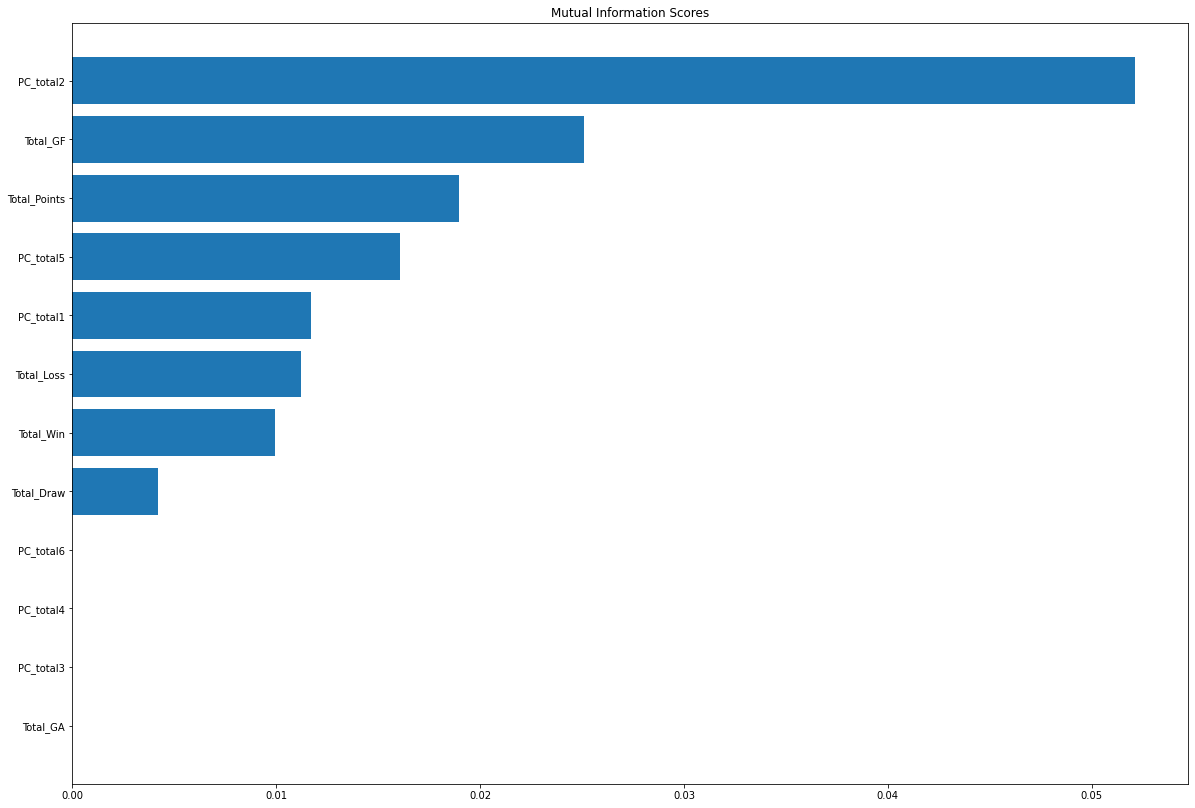

In [112]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_total.reset_index(drop=True),X_pca_total],axis=1), y_train=df4['Points'])
plot_mi_scores(scores=mi_scores_win)

<AxesSubplot:xlabel='PC_total5', ylabel='PC_total2'>

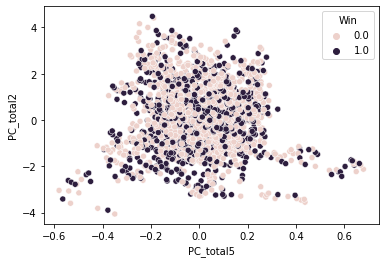

In [129]:
sns.scatterplot(X_pca_total.PC_total5,X_pca_total.PC_total2
                ,hue=df4['Win'])

<AxesSubplot:xlabel='PC_total5', ylabel='PC_total1'>

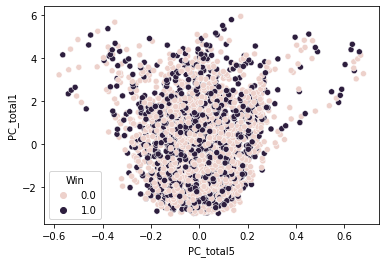

In [130]:
sns.scatterplot(X_pca_total.PC_total5,X_pca_total.PC_total1
                ,hue=df4['Win'])

<AxesSubplot:xlabel='PC_total2', ylabel='PC_total1'>

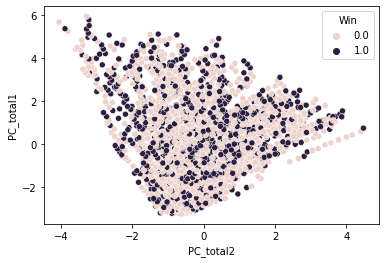

In [131]:
sns.scatterplot(X_pca_total.PC_total2,X_pca_total.PC_total1
                ,hue=df4['Win'])

In [113]:
szn_avg = 'Points_Avg_for_szn	GF_Avg_for_szn	GA_Avg_for_szn	Win_Avg_for_szn	Draw_Avg_for_szn	Loss_Avg_for_szn'.split('	')
szn_avg

['Points_Avg_for_szn',
 'GF_Avg_for_szn',
 'GA_Avg_for_szn',
 'Win_Avg_for_szn',
 'Draw_Avg_for_szn',
 'Loss_Avg_for_szn']

In [115]:
X_szn_avg = df4.loc[:,szn_avg]

In [132]:
pca_szn_avg, X_pca_szn_avg, loadings_szn_avg = apply_pca(X=X_szn_avg,alias='szn_avg')
print(loadings_szn_avg)

                    PC_szn_avg1  PC_szn_avg2  PC_szn_avg3  PC_szn_avg4  \
Points_Avg_for_szn     0.477284    -0.016018     0.040056    -0.341406   
GF_Avg_for_szn         0.428951    -0.070706     0.598196     0.673174   
GA_Avg_for_szn        -0.396505    -0.202669     0.771584    -0.454276   
Win_Avg_for_szn        0.469035    -0.177706     0.004858    -0.321854   
Draw_Avg_for_szn      -0.122825     0.897442     0.180009     0.012567   
Loss_Avg_for_szn      -0.442611    -0.341595    -0.113086     0.346646   

                     PC_szn_avg5   PC_szn_avg6  
Points_Avg_for_szn  3.864624e-01  7.102305e-01  
GF_Avg_for_szn      1.387779e-16  2.220446e-16  
GA_Avg_for_szn     -1.804112e-16 -1.110223e-16  
Win_Avg_for_szn     4.039521e-01 -6.939995e-01  
Draw_Avg_for_szn    3.694247e-01 -1.023486e-01  
Loss_Avg_for_szn    7.422903e-01  5.883857e-02  


In [118]:
X_szn_avg

,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn
4,1.000000,1.250000,2.250000,0.250000,0.250000,0.500000
6,1.666667,1.833333,1.666667,0.500000,0.166667,0.333333
8,1.750000,1.500000,1.250000,0.500000,0.250000,0.250000
10,2.000000,1.800000,1.200000,0.600000,0.200000,0.200000
11,2.090909,1.818182,1.090909,0.636364,0.181818,0.181818
...,...,...,...,...,...,...
4778,1.513514,1.135135,0.864865,0.459459,0.135135,0.405405
4779,1.473684,1.105263,0.921053,0.447368,0.131579,0.421053
4780,1.461538,1.128205,0.948718,0.435897,0.153846,0.410256
4781,1.425000,1.125000,1.050000,0.425000,0.150000,0.425000


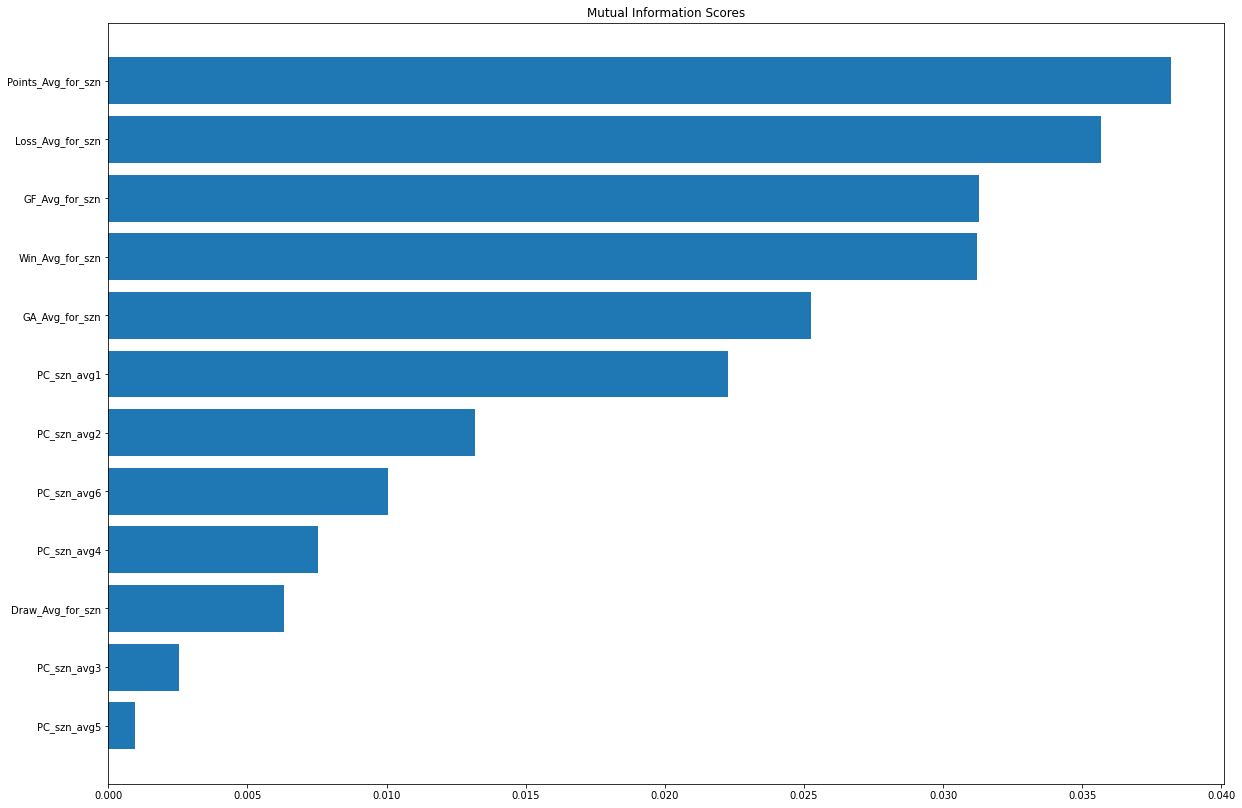

In [133]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_szn_avg.reset_index(drop=True),X_pca_szn_avg],axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_scores_win)

In [134]:
roll_2game = 'Points_last_2gm_sum	Win_last_2gm_sum	Draw_last_2gm_sum	Lose_last_2gm_sum	GF_last_2gm_sum	GA_last_2gm_sum	Away_Win_last_2gm_sum	Away_Draw_last_2gm_sum	Away_Loss_last_2gm_sum	Home_Win_last_2gm_sum	Home_Draw_last_2gm_sum	Home_Loss_last_2gm_sum'.split('	')
#cluster_list.append(roll_2game)
roll_2game  

['Points_last_2gm_sum',
 'Win_last_2gm_sum',
 'Draw_last_2gm_sum',
 'Lose_last_2gm_sum',
 'GF_last_2gm_sum',
 'GA_last_2gm_sum',
 'Away_Win_last_2gm_sum',
 'Away_Draw_last_2gm_sum',
 'Away_Loss_last_2gm_sum',
 'Home_Win_last_2gm_sum',
 'Home_Draw_last_2gm_sum',
 'Home_Loss_last_2gm_sum']

In [136]:
X_2gm = df4.loc[:,roll_2game] 

In [137]:
X_2gm

,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum
4,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0
6,6.0,2.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
8,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10,6.0,2.0,0.0,0.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0
11,6.0,2.0,0.0,0.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4778,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
4779,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0
4780,1.0,0.0,1.0,1.0,2.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0
4781,1.0,0.0,1.0,1.0,3.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0


In [138]:
pca_2gm, X_pca_2gm, loadings_2gm = apply_pca(X=X_2gm,alias='2gm')
print(loadings_2gm)

                         PC_2gm1   PC_2gm2   PC_2gm3   PC_2gm4   PC_2gm5  \
Points_last_2gm_sum     0.438909 -0.044939  0.001825  0.009956 -0.004962   
Win_last_2gm_sum        0.415113 -0.204717  0.005202  0.008099 -0.003496   
Draw_last_2gm_sum      -0.050545  0.610499 -0.013182  0.003769 -0.003894   
Lose_last_2gm_sum      -0.385807 -0.294744  0.005559 -0.011466  0.006827   
GF_last_2gm_sum         0.325601 -0.108214  0.002934 -0.001905 -0.003395   
GA_last_2gm_sum        -0.310012 -0.166988 -0.000077  0.010382 -0.036089   
Away_Win_last_2gm_sum   0.252159 -0.116091  0.609738  0.251091 -0.328322   
Away_Draw_last_2gm_sum -0.025936  0.418525 -0.021506 -0.547502 -0.441647   
Away_Loss_last_2gm_sum -0.278536 -0.220129 -0.369571  0.341035 -0.422638   
Home_Win_last_2gm_sum   0.281226 -0.145477 -0.560766 -0.224211  0.303378   
Home_Draw_last_2gm_sum -0.043233  0.409302  0.005069  0.558121  0.439373   
Home_Loss_last_2gm_sum -0.242319 -0.176366  0.420056 -0.398369  0.481695   

           

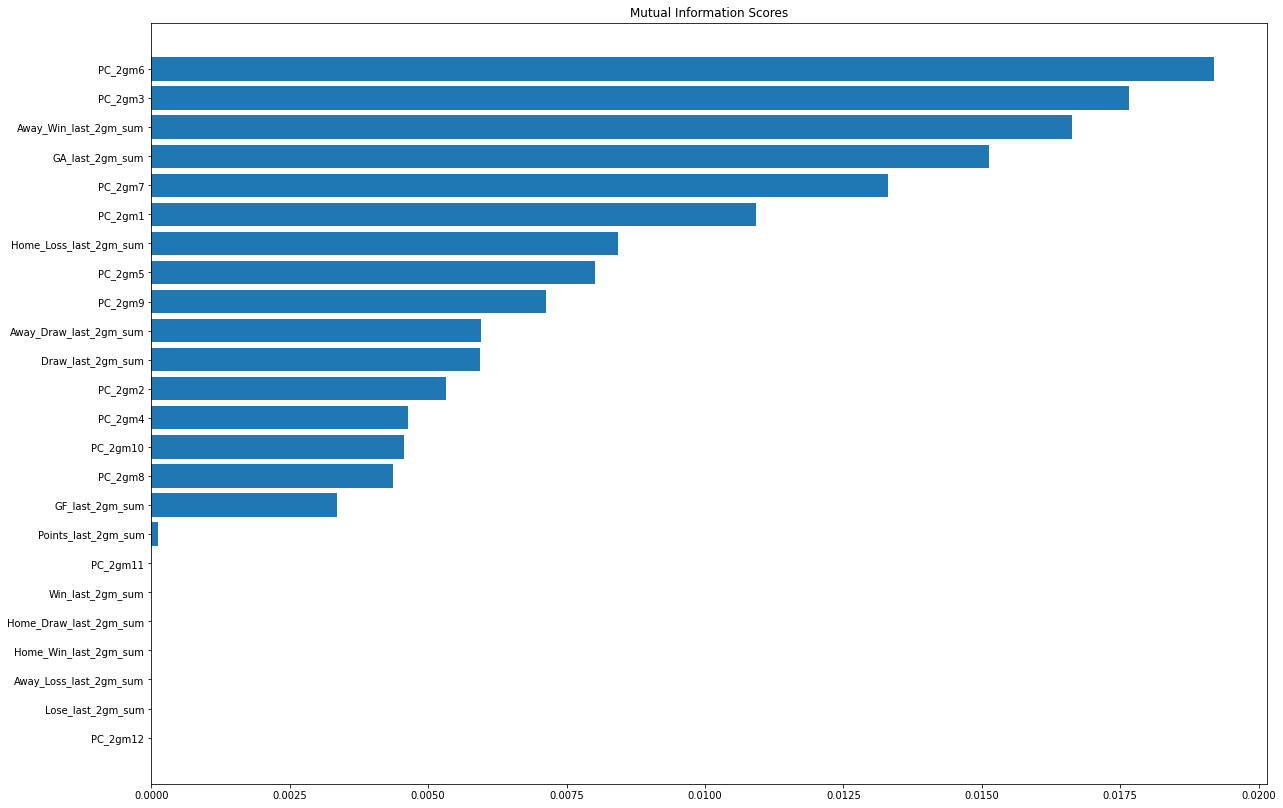

In [139]:
#win
mi_scores_win = make_mi_scores_Classif(X_train=pd.concat([X_2gm.reset_index(drop=True),X_pca_2gm],axis=1), y_train=df4['Win'])
plot_mi_scores(scores=mi_scores_win)